# Optimization Objectives.

When using ``paragami``, a typical workflow is as follows:

1. Define an objective function.
2. Define parameter patterns for the input to the objective function.
3. Flatten the input of the objective function. 
4. Use ``autograd`` to define derivatives of the flat objective.
5. Optimize.

To help reduce the boilerplate in step 4, ``paragami`` provides an ``OptimizationObjective`` class.  In addition to defining all the ``autograd`` derivatives, optimization objectives also provide basic logging and progress displays.

In [1]:
import autograd
import autograd.numpy as np
import scipy as sp
import example_utils
import matplotlib.pyplot as plt
import paragami
import time

%matplotlib inline

### Problem setup.

Let us consider again the multivariate normal objective.  The functionality in this section is described in previous notebooks.

First, define some parameters and draw data.

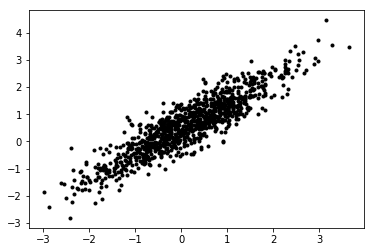

In [2]:
dim = 2
num_obs = 1000

mean_true = np.random.random(dim)
cov_true = np.random.random((dim, dim))
cov_true = 0.1 * np.eye(dim) + np.full((dim, dim), 1.0)

x = np.random.multivariate_normal(mean=mean_true, cov=cov_true, size=(num_obs, ))
plt.plot(x[:, 0], x[:, 1], 'k.')

Define ``paragami`` patterns and a loss function.

In [3]:
mvn_pattern = paragami.PatternDict(free_default=True)
mvn_pattern['mean'] = paragami.NumericVectorPattern(length=dim)
mvn_pattern['cov'] = paragami.PSDSymmetricMatrixPattern(size=dim)

# ``example_utils.get_normal_log_prob`` returns the log probability of
# each datapoint x up to a constant.
def get_loss(x, sigma, mu):
    return -1 * np.sum(
        example_utils.get_normal_log_prob(x, sigma, mu))
       
get_free_loss = paragami.FlattenFunctionInput(
    lambda mvn_par: get_loss(x=x, sigma=mvn_par['cov'], mu=mvn_par['mean']),
    patterns=mvn_pattern,
    free=True)

mvn_par = mvn_pattern.random()
mvn_free = mvn_pattern.flatten(mvn_par)

## Optimization objectives.

We can use ``get_free_loss`` to define an optimization objective and pass it to ``scipy.optimize.minimize``.

In [4]:
objective = paragami.OptimizationObjective(get_free_loss)

def Optimize(objective, x0=np.zeros(mvn_pattern.flat_length())):
    opt_result = sp.optimize.minimize(
        x0=x0,
        fun=objective.f,
        jac=objective.grad,
        hessp=objective.hessian_vector_product,
        method='trust-ncg')
    return opt_result

### Controlling printing.

The frequency of printing can be controlled with ``set_print_every()``, and the count can be reset with ``reset()``.

In [5]:
print('\nOptimizing:')
opt_result = Optimize(objective)
print(opt_result.message)

print('\nOptimizing printing less:')
objective.reset()
objective.set_print_every(5)
opt_result = Optimize(objective)
print(opt_result.message)

print('\nOptimizing without reset:')
opt_result = Optimize(objective)
print(opt_result.message)

print('\nOptimizing without printing:')
objective.set_print_every(0)
opt_result = Optimize(objective)
print(opt_result.message)



Optimizing:
Iter 0: f = 1290.22412134
Iter 1: f = 539.49481319
Iter 2: f = 449.15367362
Iter 3: f = 272.45823141
Iter 4: f = 255.05895262
Iter 5: f = 254.63015576
Iter 6: f = 254.47898697
Iter 7: f = 254.47819241
Iter 8: f = 254.47818845
Iter 9: f = 254.47818845
Optimization terminated successfully.

Optimizing printing less:
Iter 0: f = 1290.22412134
Iter 5: f = 254.63015576
Optimization terminated successfully.

Optimizing without reset:
Iter 10: f = 1290.22412134
Iter 15: f = 254.63015576
Optimization terminated successfully.

Optimizing without printing:
Optimization terminated successfully.


### Accessing derivatives.

The function value and derivatives are methods of the optimization objective.  Under the hood, all the derivatives are calcualted with ``autograd``.

In [6]:
opt_x = opt_result.x

print('f() evaluates the objective:\n{} = {}'.format(
    objective.f(opt_x), get_free_loss(opt_x)))

grad = objective.grad(opt_x)
print('\ngrad() evaluates the gradient:\n{}'.format(grad))

print('\nhessian() evaluates the Hessian matrix:\n{}'.format(objective.hessian(opt_x)))

print('\nhessian_vector_product() evaluates the Hessian-vector product:\n{}'.format(
    objective.hessian_vector_product(opt_x, grad)))

f() evaluates the objective:
254.47818844774238 = 254.47818844774238

grad() evaluates the gradient:
[-9.38462682e-07 -8.28401150e-07  1.12731491e-06 -9.35645267e-07
  3.23708426e-06]

hessian() evaluates the Hessian matrix:
[[ 4.80152064e+03 -4.37310150e+03  9.83363903e-06 -6.91901344e-06
  -1.47624300e-06]
 [-4.37310150e+03  4.90797543e+03 -8.10149773e-06  8.64973804e-06
   1.65680224e-06]
 [ 9.83363896e-06 -8.10149785e-06  6.30553475e+03 -4.59689665e+03
  -1.75268882e-06]
 [-6.91901349e-06  8.64973810e-06 -4.59689665e+03  4.90797543e+03
   1.87129286e-06]
 [-1.47624310e-06  1.65680237e-06 -1.75268281e-06  1.87129159e-06
   1.99999999e+03]]

hessian_vector_product() evaluates the Hessian-vector product:
[-8.83365609e-04  3.82200615e-05  1.14093879e-02 -9.77427408e-03
  6.47416850e-03]


### Logging.

By default, an optimization objective does no logging.  But by using ``set_log_every`` with a number larger than ``0``, a log of the values is kept.

In [7]:
print('\nOptimizing with logging:')
objective.reset()
objective.set_print_every(0)
objective.set_log_every(2)
opt_result = Optimize(objective)
print(opt_result.message)


Optimizing with logging:
Optimization terminated successfully.


The log is contained in the attribute ``optimization_log``.  By default, each entry in the log is a tuple containing the iteration number, argument, and function value.

(0, array([0., 0., 0., 0., 0.]), 1290.2241213426291)
(2, array([ 0.09798938,  0.57638205,  0.10194361,  0.92848007, -1.16334881]), 449.1536736241908)
(4, array([ 0.10983197,  0.58725075,  0.05844622,  0.94244548, -0.80874364]), 255.05895261654913)
(6, array([ 0.13464741,  0.61326864,  0.04907768,  0.9356453 , -0.7953923 ]), 254.47898697444145)
(8, array([ 0.13480492,  0.61343579,  0.04990915,  0.93661793, -0.79543076]), 254.4781884477883)


Text(0.5, 0, 'Difference from optimum')

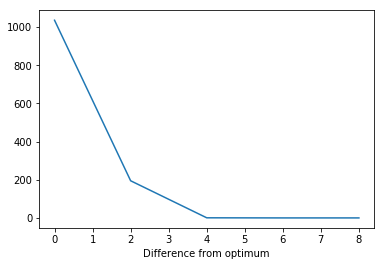

In [8]:
for log_entry in objective.optimization_log:
    print(log_entry)

plt.plot(
    [ entry[0] for entry in objective.optimization_log],
    [ entry[2] - opt_result.fun for entry in objective.optimization_log])
plt.xlabel('Iteration')
plt.xlabel('Difference from optimum')

The method ``reset()`` clears the log as well as the iteration count.  Note that you can clear the log only using ``reset_log()`` and clear the iteration count only using ``reset_iteration_count()``.

In [9]:
objective.reset()
print(objective.optimization_log)

[]


### Overloading.

Both the logging and progress methods can be overloaded to provide custom behavior.

In [17]:
class CustomObjective(paragami.OptimizationObjective):
    def print_value(self, num_f_evals, x, f_val):
        grad = objective.grad(x)
        print('Iteration {}: gradient norm = {:0.8f}'.format(
            num_f_evals, np.linalg.norm(grad)))

    def log_value(self, num_f_evals, x, f_val):
        grad = self.grad(x)
        self.optimization_log.append((num_f_evals, np.linalg.norm(grad)))

custom_objective = CustomObjective(get_free_loss)


Optimizing with custom printing and logging:
Iteration 0: gradient norm = 1325.81210303
Iteration 1: gradient norm = 822.69307418
Iteration 2: gradient norm = 1380.15778047
Iteration 3: gradient norm = 343.45510333
Iteration 4: gradient norm = 44.95265409
Iteration 5: gradient norm = 14.74702496
Iteration 6: gradient norm = 1.23658409
Iteration 7: gradient norm = 0.09246396
Iteration 8: gradient norm = 0.00029502
Iteration 9: gradient norm = 0.00000377
Optimization terminated successfully.


Text(0.5, 0, 'Log gradient norm')

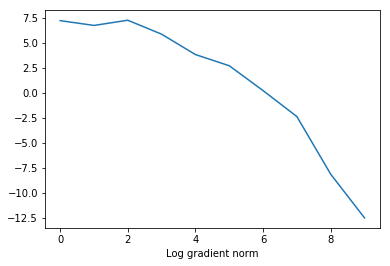

In [22]:
print('\nOptimizing with custom printing and logging:')
custom_objective.reset()
custom_objective.set_print_every(1)
custom_objective.set_log_every(1)
opt_result = Optimize(custom_objective)
print(opt_result.message)

plt.plot(
    [ entry[0] for entry in custom_objective.optimization_log],
    np.log([ entry[1] for entry in custom_objective.optimization_log]))
plt.xlabel('Iteration')
plt.xlabel('Log gradient norm')